<a href="https://colab.research.google.com/github/AlineBarrucci26/Estudo_case_GB/blob/main/case_neon_fina.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Case Neon

https://www.kaggle.com/datasets/uciml/default-of-credit-card-clients-dataset/data

# Desafio

- How was the end-to-end development of the project done?
- Which variables are the strongest predictors of default payment?
- How does the probability of default payment vary by categories of different variables?
- What would be the best alternatives to increase the predictive power of the model?
- What is your suggestion for implementing the developed model in practice?

- What metrics do you use to track the model over time?

------------------------------------------------------------------------------------------------------------

In [ ]:
!pip install xgboost
! pip install optuna

In [ ]:
#bicliotecas a serem utilizadas no desenvolvimento
import pandas as pd
import numpy as np
pd.set_option("display.max.columns", None)

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
from scipy import stats
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier
import optuna
#from sklearn.metrics import fbeta_score, make_scorer
from scipy.stats import ks_2samp

In [ ]:
#leitura do data frame
df = pd.read_csv('./UCI_Credit_Card.csv',sep = ',')

In [ ]:
df.head(3)

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


In [ ]:
df.shape

(30000, 25)

In [ ]:
#check ID (chave) em duplicidade
df["ID"].duplicated().sum()

0

# EDA - Analise exploratoria

In [ ]:
#tipos de variaveis
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [ ]:
#estatisticas basicas
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [ ]:
# Verificando valores ausentes
print(df.isnull().sum())

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


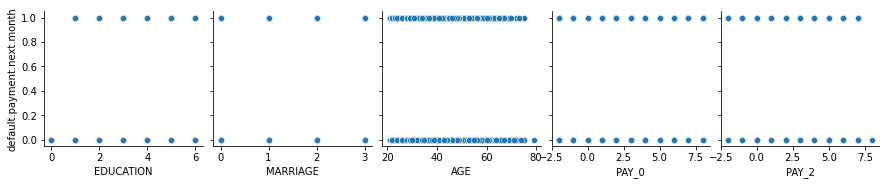

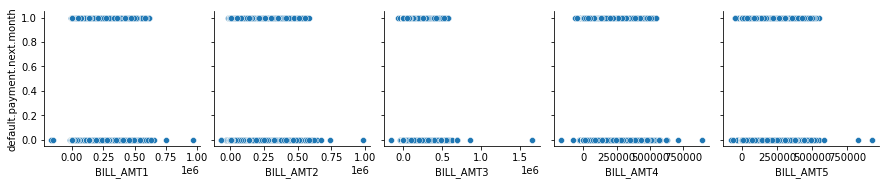

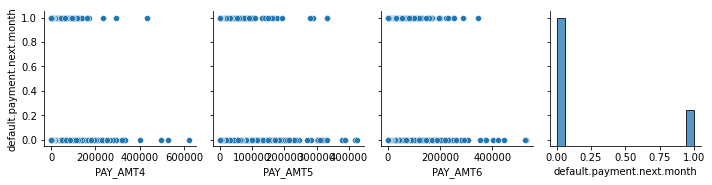

In [ ]:
## analise de distribuição da variavel target em relação  as variaveis explicativas

for i in range(3, len(df.columns), 9):
    sns.pairplot(data=df,
                x_vars=df.columns[i:i+5],
                y_vars=['default.payment.next.month'])

array([[<AxesSubplot:title={'center':'ID'}>,
        <AxesSubplot:title={'center':'LIMIT_BAL'}>,
        <AxesSubplot:title={'center':'SEX'}>,
        <AxesSubplot:title={'center':'EDUCATION'}>,
        <AxesSubplot:title={'center':'MARRIAGE'}>],
       [<AxesSubplot:title={'center':'AGE'}>,
        <AxesSubplot:title={'center':'PAY_0'}>,
        <AxesSubplot:title={'center':'PAY_2'}>,
        <AxesSubplot:title={'center':'PAY_3'}>,
        <AxesSubplot:title={'center':'PAY_4'}>],
       [<AxesSubplot:title={'center':'PAY_5'}>,
        <AxesSubplot:title={'center':'PAY_6'}>,
        <AxesSubplot:title={'center':'BILL_AMT1'}>,
        <AxesSubplot:title={'center':'BILL_AMT2'}>,
        <AxesSubplot:title={'center':'BILL_AMT3'}>],
       [<AxesSubplot:title={'center':'BILL_AMT4'}>,
        <AxesSubplot:title={'center':'BILL_AMT5'}>,
        <AxesSubplot:title={'center':'BILL_AMT6'}>,
        <AxesSubplot:title={'center':'PAY_AMT1'}>,
        <AxesSubplot:title={'center':'PAY_AMT2'}>],
  

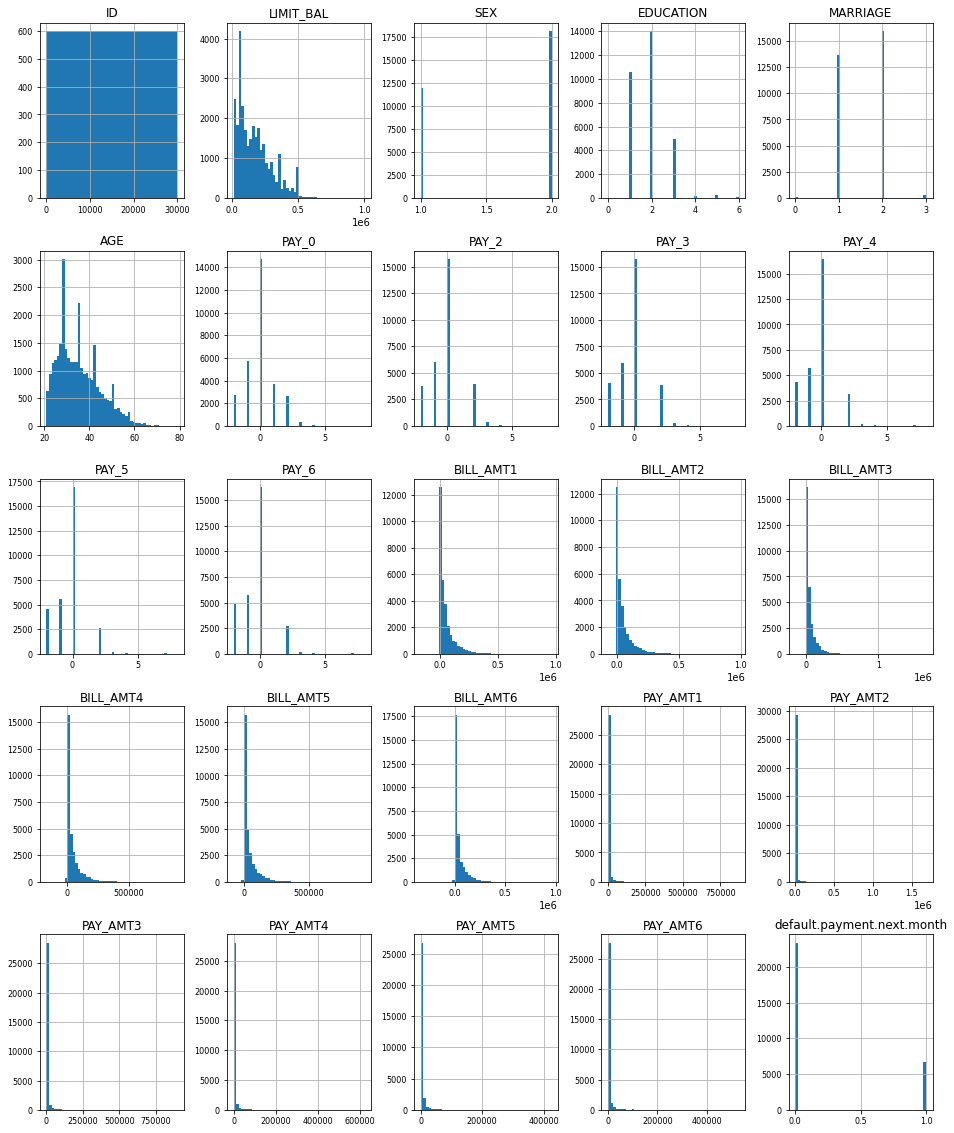

In [ ]:
# distruibuição das variaveis explicativas
df.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [ ]:
df['default.payment.next.month'].describe()

count    30000.000000
mean         0.221200
std          0.415062
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: default.payment.next.month, dtype: float64

# Pré-processamento de Dados

In [ ]:
# A variavel sex está com homem = 1 e mulher = 2 isso pode parecer que existe uma relação ordinal entre as categorias. Dado isso será alterado, se valor for 2 será igual a 1 e se 1 sera igual a 0 transformando a variavel numa flag

df['SEX'] = df['SEX'].apply(lambda x: 1 if x == 2 else 0)

### estudo dos outliers

In [ ]:
estatisticas_descritivas = df.describe()
p99 = df.quantile(0.99)
estatisticas_descritivas.loc['p99'] = p99
estatisticas_descritivas

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000
p99,29700.010000,500000.000000,2.000000,5.000000,3.000000,60.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,350110.680000,337495.280000,3.250304e+05,304997.270000,285868.330000,279505.060000,66522.180000,7.665102e+04,70000.00000,67054.440000,65607.560000,82619.050000,1.000000


In [ ]:
variaveis_a_remover_outliers = ['BILL_AMT1', 'BILL_AMT2', 'BILL_AMT4','BILL_AMT5','BILL_AMT6','PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']

limite_p99 = df[variaveis_a_remover_outliers].quantile(0.99)
mascara_outliers = (df[variaveis_a_remover_outliers] <= limite_p99).all(axis=1)
dados_sem_outliers = df[mascara_outliers]
print(f"Número de linhas após remoção de outliers: {dados_sem_outliers.shape[0]}")

Número de linhas após remoção de outliers: 28097


In [ ]:
df = dados_sem_outliers

### Correlação das variaveis

<AxesSubplot:>

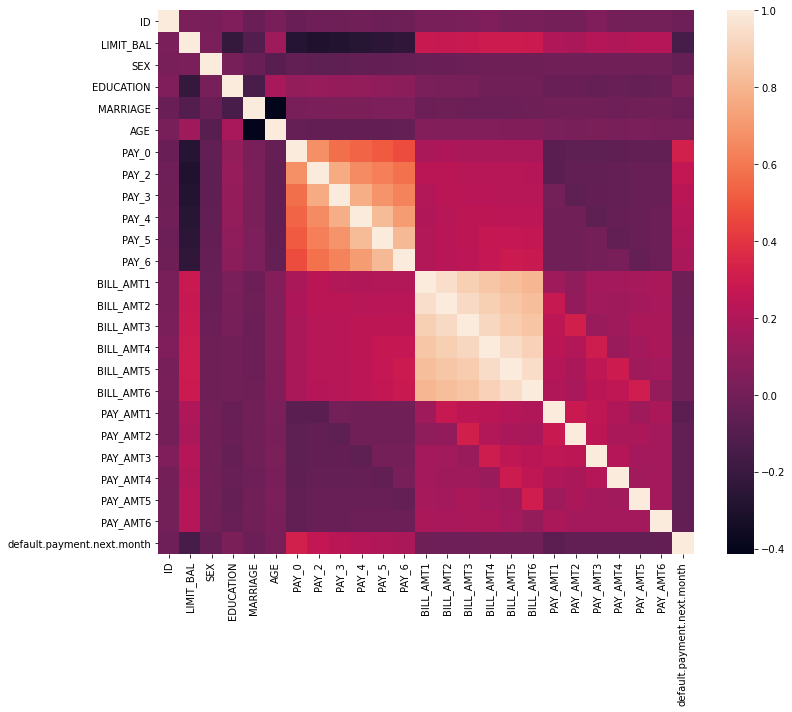

In [ ]:
#grafico de correlacao
plt.rcParams['figure.figsize'] = (12, 10)
sns.heatmap(df.corr())

In [ ]:
# Funcao que calcula correlação das variaveis explicativas
def correlation(dataset, threshold):
    col_corr = set()
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):

        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])
                colname = corr_matrix.columns[j]
                col_corr.add(colname)

    return col_corr

In [ ]:
# Remocao das variaveis com correção acima de 90%
corr_features = correlation(df, 0.9)
len(set(corr_features))

0.9641206404079903 BILL_AMT2 BILL_AMT1
0.929500167692354 BILL_AMT3 BILL_AMT1
0.9623831538868975 BILL_AMT3 BILL_AMT2
0.9214622281619103 BILL_AMT4 BILL_AMT2
0.953831450424314 BILL_AMT4 BILL_AMT3
0.920191516495905 BILL_AMT5 BILL_AMT3
0.9619051835345099 BILL_AMT5 BILL_AMT4
0.9373488220644077 BILL_AMT6 BILL_AMT4
0.9713191955630617 BILL_AMT6 BILL_AMT5


5

In [ ]:
df.drop(labels=corr_features, axis=1, inplace=True)

In [ ]:
df.shape

(28097, 20)

### Seleção das variaveis

In [ ]:
features = df.columns[1:-1]

In [ ]:
features

Index(['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2',
       'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2',
       'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6'],
      dtype='object')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df[features],df['default.payment.next.month'],test_size=0.3,random_state=42)

In [ ]:
def train_and_evaluate(features):
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train[features], y_train)
    y_pred = model.predict_proba(X_test[features])[:, 1]
    auc = roc_auc_score(y_test, y_pred)
    return auc

In [ ]:
results = []

In [ ]:
all_features = X_train.columns.tolist()

In [ ]:
for i in range(len(all_features), 0, -1):
    current_features = all_features[:i]
    auc = train_and_evaluate(current_features)
    results.append((i, auc))

In [ ]:
best_num_features, best_auc = max(results, key=lambda x: x[1])
best_features = all_features[:best_num_features]

In [ ]:
print(f"O número ideal de variáveis é: {best_num_features}")
print(f"AUC correspondente: {best_auc}")
print(f"Variáveis ideais: {best_features}")

O número ideal de variáveis é: 17
AUC correspondente: 0.7586496686633547
Variáveis ideais: ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']


In [ ]:
features_final = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5']

# Treinando o modelo

In [ ]:
# Divindo a base em densenvolvimento e validação (oot-time)
X_dens, X_val, y_dens, y_val = train_test_split(df[features_final], df['default.payment.next.month'], test_size=0.3,random_state=0)
X_dens.shape, X_val.shape

((19667, 17), (8430, 17))

In [ ]:
#Divisao base desenvolvimento em treino e teste
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_dens, y_dens, test_size=0.3,random_state=0)
X_train.shape, X_test.shape

((13766, 17), (5901, 17))

### Otimizador de hiperparametros

In [ ]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',
        'booster': trial.suggest_categorical('booster', ['gbtree', 'gblinear', 'dart']),
        'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
        'max_depth': trial.suggest_int('max_depth', 1, 9),
        'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.0, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)


    y_pred = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_pred)

    return auc

In [ ]:
#estudo Optuna e otimize
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

[I 2024-01-11 20:11:50,263] A new study created in memory with name: no-name-89e4c7cc-b904-4295-9886-e39a62e98b05
<ipython-input-57-f903170c0d2c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 1.

[20:11:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.



[I 2024-01-11 20:11:57,273] Trial 9 finished with value: 0.769519918733778 and parameters: {'booster': 'gbtree', 'lambda': 0.00034617417115819985, 'alpha': 6.593309642189017e-05, 'max_depth': 6, 'eta': 5.300280230357275e-07, 'gamma': 0.010615823334750155, 'colsample_bytree': 0.13559487519122015, 'min_child_weight': 6}. Best is trial 4 with value: 0.776782607227277.
<ipython-input-57-f903170c0d2c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:10: 

[20:11:59] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.



[I 2024-01-11 20:12:00,633] Trial 12 finished with value: 0.7739631719387842 and parameters: {'booster': 'dart', 'lambda': 1.1899434537051429e-06, 'alpha': 0.0008695029306682543, 'max_depth': 7, 'eta': 1.7894045633800285e-05, 'gamma': 0.25855092237638416, 'colsample_bytree': 0.6414188828847043, 'min_child_weight': 9}. Best is trial 4 with value: 0.776782607227277.
<ipython-input-57-f903170c0d2c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:10: F

[20:12:01] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.



[I 2024-01-11 20:12:02,137] Trial 15 finished with value: 0.7697023571641187 and parameters: {'booster': 'gbtree', 'lambda': 3.033550753794476e-05, 'alpha': 0.48511070899752057, 'max_depth': 8, 'eta': 2.0218236364338502e-08, 'gamma': 0.0060082987540211906, 'colsample_bytree': 0.37831032723731167, 'min_child_weight': 8}. Best is trial 4 with value: 0.776782607227277.
<ipython-input-57-f903170c0d2c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:10:

[20:12:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.



[I 2024-01-11 20:12:06,866] Trial 20 finished with value: 0.7739241844157848 and parameters: {'booster': 'dart', 'lambda': 6.278645766359656e-06, 'alpha': 1.5259089199536277e-05, 'max_depth': 6, 'eta': 0.0040747502821354255, 'gamma': 1.372980143838781e-07, 'colsample_bytree': 0.6024996520500314, 'min_child_weight': 8}. Best is trial 4 with value: 0.776782607227277.
<ipython-input-57-f903170c0d2c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:10: 

[20:12:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.



<ipython-input-57-f903170c0d2c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feat

[20:12:44] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.



<ipython-input-57-f903170c0d2c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feat

[20:12:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.



<ipython-input-57-f903170c0d2c>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:12: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.0, 1.0),
[I 2024-01-11 20:12:54,274] Trial 51 finished with value: 0.7760266134957422 and parameters: {'booster': 'dart

[20:13:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.



<ipython-input-57-f903170c0d2c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feat

[20:14:06] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight" } are not used.



<ipython-input-57-f903170c0d2c>:7: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'lambda': trial.suggest_loguniform('lambda', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:8: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'alpha': trial.suggest_loguniform('alpha', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  'eta': trial.suggest_loguniform('eta', 1e-8, 1.0),
<ipython-input-57-f903170c0d2c>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feat

In [ ]:
print('Número de iterações: ', len(study.trials))
print('Melhor resultado: ', study.best_value)
print('Melhores hiperparâmetros: ', study.best_params)

Número de iterações:  100
Melhor resultado:  0.7793975856541808
Melhores hiperparâmetros:  {'booster': 'dart', 'lambda': 0.8772056114195729, 'alpha': 4.2974181965344104e-05, 'max_depth': 6, 'eta': 0.07546655870761754, 'gamma': 0.0003959920179080056, 'colsample_bytree': 0.30972139442572455, 'min_child_weight': 9}


In [ ]:
params =  {'booster': 'gbtree', 'lambda': 2.1959188975418712e-05, 'alpha': 0.00010646631634838134, 'max_depth': 9, 'eta': 3.681247056663854e-06, 'gamma': 6.016064414609729e-07, 'colsample_bytree': 0.5825676136789031, 'min_child_weight': 6, 'booster': 'gbtree'
        }

In [ ]:
# Treino do modelo
xgb_clf = xgb.XGBClassifier(**params)

xgb_clf.fit(X_train, y_train)

XGBClassifier(alpha=0.00010646631634838134, base_score=None, booster='gbtree',
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.5825676136789031, early_stopping_rounds=None,
              enable_categorical=False, eta=3.681247056663854e-06,
              eval_metric=None, feature_types=None, gamma=6.016064414609729e-07,
              gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=2.1959188975418712e-05,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=9,
              max_leaves=None, min_child_weight=6, missing=nan,
              monotone_constraints=None, n_estimators=100, n_jobs=None, ...)

#  Feature Importance

In [ ]:
explainer = shap.TreeExplainer(xgb_clf)
shap_values = explainer.shap_values(X_train)

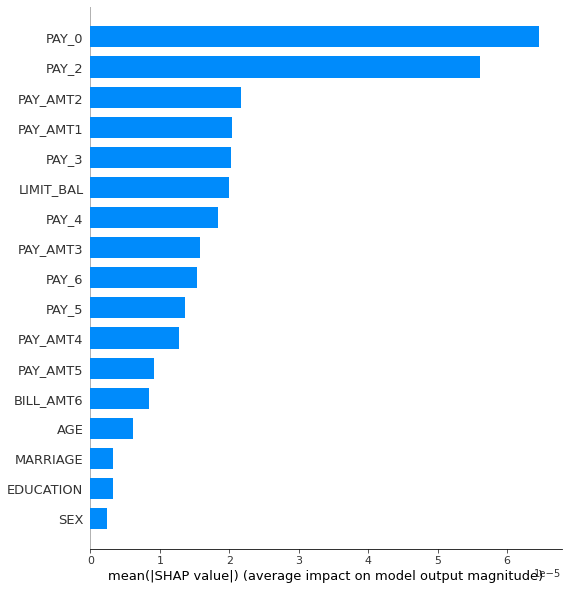

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type="bar")

plt.show()

# Metricas de avaliação de performance

In [ ]:
X_train['prob'] = xgb_clf.predict_proba(X_train[features_final].values)[:,0]
X_test['prob'] = xgb_clf.predict_proba(X_test[features_final].values)[:,0]
X_val['prob'] = xgb_clf.predict_proba(X_val[features_final].values)[:,0]

In [ ]:
print(f"""
- AUC Treino: {roc_auc_score(1-y_train.astype(int).values, X_train['prob'].values)}
- AUC teste: {roc_auc_score(1-y_test.astype(int).values, X_test['prob'].values)}
- AUC validacao: {roc_auc_score(1-y_val.astype(int).values, X_val['prob'].values)}
""")

 
- AUC Treino: 0.8334291313042379
- AUC teste: 0.7756994825172
- AUC validacao: 0.7816261758205688



In [ ]:
X_train['pred'] = xgb_clf.predict(X_train[features_final].values)
X_test['pred'] = xgb_clf.predict(X_test[features_final].values)
X_val['pred'] = xgb_clf.predict(X_val[features_final].values)

In [ ]:
print(f"""
- Acuracy score treino:{ accuracy_score(y_train, X_train['pred'])}
- Acuracy score teste:{ accuracy_score(y_test, X_test['pred'])}
- Acuracy score validacao:{accuracy_score(y_val, X_val['pred'])}
""")


- Acuracy score treino:0.8212988522446607
- Acuracy score teste:0.8078291814946619
- Acuracy score validacao:0.8120996441281139



In [ ]:
#funcao KS

def ks_stat(y,yhat):
    return ks_2samp(yhat[y==1], yhat[y!=1]).statistic
ks_score = make_scorer(ks_stat)

In [ ]:
print(f"""
- KS treino:{ ks_stat(y_train.astype(int),X_train['pred'])}
- KS teste:{ ks_stat(y_test.astype(int),X_test['pred'])}
- KS validacao:{ ks_stat(y_val.astype(int),X_val['pred'])}
""")


- KS treino:0.29603597015127503
- KS teste:0.24122466183497301
- KS validacao:0.25411881812396736



# Conclusoes

In [ ]:
O modelo parece ter um bom desempenho geral, mas há uma diferença entre os conjuntos de treino e teste,
o que pode indicar alguma tendência para overfitting que realmente está relacionado a quantidade de dados (30 mil linhas) que pode influenciar o desempenho do modelo.
Em conjuntos de dados menores, há um risco maior de overfittin.